In [7]:
import pandas as pd
import os
import sys
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix
sys.path.insert(1, '../src/')
from CNN_classifier_model import CNNClassifier, train_model, evaluate_model
from config import raw_data_path, univariate_data_path, processed_data_path, results_path
import re
import numpy as np
# Load the saved predictions


file_name = 'results_ResNet_SGD_all_runs.csv'

path = os.path.join(results_path, file_name)
df = pd.read_csv(path)

def extract_base_record_id(window_id):
    # Remove the '-chanX-window_index' part
    return re.sub(r'-chan\d+-\d+$', '', window_id)

df['base_record_id'] = df['window_id'].apply(extract_base_record_id)

# Get all unique base_record_ids
unique_base_ids = df['base_record_id'].unique()

# Print them all
for base_id in unique_base_ids:
    print(base_id)

# Print total count
print(f"\nTotal unique base record_ids (aggregated across channels and windows): {len(unique_base_ids)}")

Hopper-2022_02_12_13_39_48-0000010181-0001
Hopper-2023_03_02_10_50_28-0000010181-0003
Hopper-2022_06_15_22_05_04-0000010181-0003
Hopper-2023_05_25_12_03_38-0000010090-0003
Hopper-2022_04_27_18_22_22-0000010090-0002
Hopper-2022_08_30_11_59_37-0000010181-0002
Hopper-2023_01_30_12_37_54-0000010090-0001
Hopper-2024_08_29_13_50_20-0000010009-0003
Hopper-2024_02_19_16_29_05-0000010009-0001
Hopper-2024_01_26_16_38_34-0000010009-0002
Hopper-2023_12_15_18_44_51-0000010181-0005
Hopper-2023_08_29_12_15_04-0000010181-0004
Hopper-2022_12_02_13_27_01-0000010090-0003
Hopper-2023_07_20_07_20_39-0000010181-0001
Hopper-2021_11_18_15_50_57-0000010090-0004
Hopper-2022_02_11_12_58_15-0000010090-0001
Hopper-2022_10_18_15_10_38-0000010181-0001
Hopper-2024_08_28_15_01_03-0000010009-0002
Hopper-2024_11_03_17_27_01-0000010179-0003
Hopper-2022_03_29_14_08_51-0000010090-0003
Hopper-2023_08_10_21_38_16-0000010090-0002
Hopper-2021_11_26_20_26_59-0000010181-0006
Hopper-2022_10_02_07_44_52-0000010181-0003
Hopper-2021


🎯 Best Run (based on AP) Metrics:
Number of patients: 32
Accuracy:  0.4688
Precision: 0.6667
Recall:    0.3000
F1-score:  0.4138
AUC:       0.5875
AP Score:  0.745581585242955

📊 Confusion Matrix:
[[ 9  3]
 [14  6]]

📃 Classification Report:
              precision    recall  f1-score   support

           0     0.3913    0.7500    0.5143        12
           1     0.6667    0.3000    0.4138        20

    accuracy                         0.4688        32
   macro avg     0.5290    0.5250    0.4640        32
weighted avg     0.5634    0.4688    0.4515        32



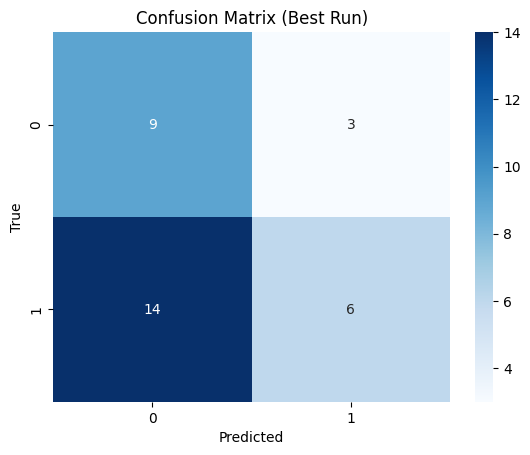

In [8]:
# import pandas as pd
# import numpy as np
# import re
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.metrics import (
#     accuracy_score, precision_score, recall_score, f1_score,
#     roc_auc_score, average_precision_score, confusion_matrix,
#     classification_report
# )

# # Load CSV
# df = pd.read_csv("results_ResNet_SGD_all_runs.csv")

# Extract base record_id (remove '-chanX-window')
def extract_base_record_id(window_id):
    return re.sub(r"-chan\d+-\d+$", "", window_id)

df["base_record_id"] = df["window_id"].apply(extract_base_record_id)

# Aggregate by patient
aggregated = df.groupby("base_record_id").agg({
    "best_pred_label": lambda x: np.bincount(x).argmax(),  # Majority vote
    "target": lambda x: x.iloc[0],                         # Same target per patient
    "best_pred_prob": "mean"                               # Mean probability
}).reset_index()

# Extract final values
y_true = aggregated["target"].values
y_pred = aggregated["best_pred_label"].values
y_probs = aggregated["best_pred_prob"].values

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
try:
    auc = roc_auc_score(y_true, y_probs)
except ValueError:
    auc = "Undefined (only one class present)"
try:
    ap = average_precision_score(y_true, y_probs)
except ValueError:
    ap = "Undefined (only one class present)"
cm = confusion_matrix(y_true, y_pred)

# Print results
print("\n🎯 Best Run (based on AP) Metrics:")
print(f"Number of patients: {len(aggregated)}")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"AUC:       {auc}")
print(f"AP Score:  {ap}")

print("\n📊 Confusion Matrix:")
print(cm)

print("\n📃 Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Best Run)')
plt.show()



📊 Aggregated Metrics over 5 Runs:

Accuracy  : 0.3937 ± 0.0419
Precision : 0.5333 ± 0.0745
Recall    : 0.1000 ± 0.1118
F1        : 0.1555 ± 0.1444
Auc       : 0.5933 ± 0.0214
Ap        : 0.7169 ± 0.0220

🧩 Confusion Matrix (Best Run):
[[ 9  3]
 [14  6]]

📃 Classification Report (Best Run):
              precision    recall  f1-score   support

           0     0.3913    0.7500    0.5143        12
           1     0.6667    0.3000    0.4138        20

    accuracy                         0.4688        32
   macro avg     0.5290    0.5250    0.4640        32
weighted avg     0.5634    0.4688    0.4515        32



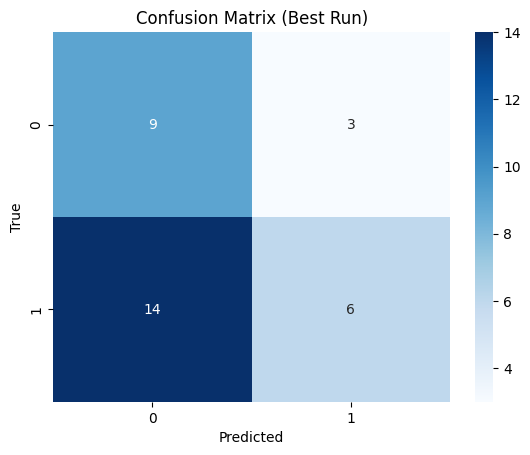

In [9]:
# Extract base record_id (remove '-chanX-window')
def extract_base_record_id(window_id):
    return re.sub(r"-chan\d+-\d+$", "", window_id)

df["base_record_id"] = df["window_id"].apply(extract_base_record_id)

# Determine number of runs
run_indices = sorted(set(int(col.replace("pred_label", "")) for col in df.columns if col.startswith("pred_label")))

# Store per-run metrics
metrics_list = []

for i in run_indices:
    label_col = f"pred_label{i}"
    prob_col = f"pred_prob{i}"

    # Group by base_record_id and aggregate per patient
    aggregated = df.groupby("base_record_id").agg({
        label_col: lambda x: np.bincount(x).argmax(),  # Majority vote
        "target": lambda x: x.iloc[0],                 # Assume same target per patient
        prob_col: "mean"
    }).reset_index()

    y_true = aggregated["target"].values
    y_pred = aggregated[label_col].values
    y_probs = aggregated[prob_col].values

    try:
        auc = roc_auc_score(y_true, y_probs)
    except ValueError:
        auc = np.nan

    try:
        ap = average_precision_score(y_true, y_probs)
    except ValueError:
        ap = np.nan

    metrics_list.append({
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "auc": auc,
        "ap": ap
    })

# Convert to DataFrame and compute mean + std
metrics_df = pd.DataFrame(metrics_list)
mean_metrics = metrics_df.mean()
std_metrics = metrics_df.std()

print(f"\n📊 Aggregated Metrics over {len(run_indices)} Runs:\n")
for metric in mean_metrics.index:
    print(f"{metric.capitalize():<10}: {mean_metrics[metric]:.4f} ± {std_metrics[metric]:.4f}")

# Confusion matrix from best run (optional — pick run 1 or the best AP run)
best_run_idx = int(metrics_df["ap"].idxmax()) + 1
label_col = f"pred_label{best_run_idx}"
aggregated = df.groupby("base_record_id").agg({
    label_col: lambda x: np.bincount(x).argmax(),
    "target": lambda x: x.iloc[0],
}).reset_index()


y_pred = aggregated[label_col].values
y_true = aggregated["target"].values

cm = confusion_matrix(y_true, y_pred)
print("\n🧩 Confusion Matrix (Best Run):")
print(cm)
print("\n📃 Classification Report (Best Run):")
print(classification_report(y_true, y_pred, digits=4))

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Best Run)')
plt.show()